In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
folder_path = 'Data/images/cropped_50'
image_size = (50, 50)

In [3]:
def load_data_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        label = 1 if filename.endswith('T.png') else 0  # 1 for 'T' (with helmet), 0 for 'F' (without helmet)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
images, labels = load_data_from_folder(folder_path)

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [5]:
print(X_train.shape)
print(X_test.shape)

(556, 50, 50, 3)
(140, 50, 50, 3)


In [6]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

model.save('helmet_detection_model.keras')

Epoch 1/50
18/18 [==============================] - 2s 83ms/step - loss: 10.7061 - accuracy: 0.6727 - val_loss: 0.8937 - val_accuracy: 0.7857
Epoch 2/50
18/18 [==============================] - 1s 70ms/step - loss: 0.4981 - accuracy: 0.8040 - val_loss: 0.4187 - val_accuracy: 0.7857
Epoch 3/50
18/18 [==============================] - 1s 71ms/step - loss: 0.3661 - accuracy: 0.8219 - val_loss: 0.3800 - val_accuracy: 0.8571
Epoch 4/50
18/18 [==============================] - 1s 78ms/step - loss: 0.3152 - accuracy: 0.8615 - val_loss: 0.3877 - val_accuracy: 0.8000
Epoch 5/50
18/18 [==============================] - 1s 73ms/step - loss: 0.2897 - accuracy: 0.8579 - val_loss: 0.3427 - val_accuracy: 0.8857
Epoch 6/50
18/18 [==============================] - 1s 78ms/step - loss: 0.1801 - accuracy: 0.9353 - val_loss: 0.2631 - val_accuracy: 0.8857
Epoch 7/50
18/18 [==============================] - 1s 82ms/step - loss: 0.1084 - accuracy: 0.9586 - val_loss: 0.2599 - val_accuracy: 0.8929
Epoch 8/50
1

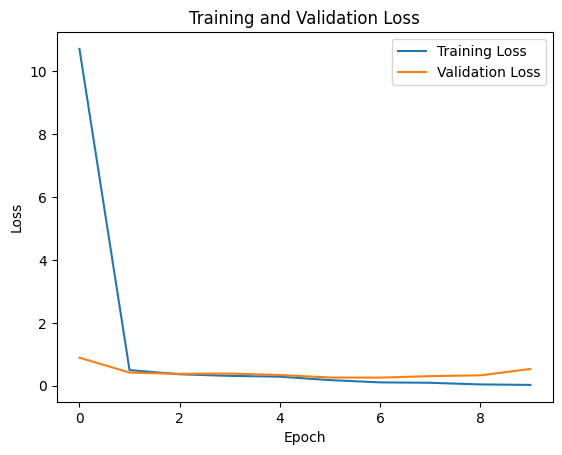

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Auto Hyperparameter tuning

In [10]:
import optuna

C:\Users\WHR\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def create_cnn_model(trial):
    model = Sequential()
    model.add(Conv2D(filters=trial.suggest_int('fileters',16,128,log=True), kernel_size=(5,5), activation='relu', input_shape=(50, 50, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=trial.suggest_int('fileters',16,128,log=True), kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=trial.suggest_int('fileters',16,128,log=True), kernel_size=(5,5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=trial.suggest_int('units',32,256,log=True), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
def objective(trial):
    model = create_cnn_model(trial)
    model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    score = model.evaluate(X_test,y_test,verbose=0)
    return score[1]

In [14]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_trial = study.best_trial
print(f"Best trial - Accuracy: {best_trial.value:.4f}, Parameters: {best_trial.params}")

[I 2023-11-18 21:09:34,574] A new study created in memory with name: no-name-7f31b156-4d81-42a9-ae0d-be9611deea76
[I 2023-11-18 21:10:30,663] Trial 0 finished with value: 0.8857142925262451 and parameters: {'fileters': 95, 'units': 107}. Best is trial 0 with value: 0.8857142925262451.
[I 2023-11-18 21:10:39,478] Trial 1 finished with value: 0.8500000238418579 and parameters: {'fileters': 33, 'units': 71}. Best is trial 0 with value: 0.8857142925262451.
[I 2023-11-18 21:10:52,190] Trial 2 finished with value: 0.9071428775787354 and parameters: {'fileters': 53, 'units': 36}. Best is trial 2 with value: 0.9071428775787354.
[I 2023-11-18 21:11:14,976] Trial 3 finished with value: 0.8857142925262451 and parameters: {'fileters': 89, 'units': 222}. Best is trial 2 with value: 0.9071428775787354.
[I 2023-11-18 21:11:24,658] Trial 4 finished with value: 0.8785714507102966 and parameters: {'fileters': 29, 'units': 32}. Best is trial 2 with value: 0.9071428775787354.
[I 2023-11-18 21:11:39,146] T

Best trial - Accuracy: 0.9357, Parameters: {'fileters': 85, 'units': 58}
